Install appropriate packages and load in datasets from NHANES

In [1]:
# !pip install xport pandas numpy matplotlib scikit-learn

In [2]:
from xport import XportReader
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# DPQ_L.xpt is the dataset containg depression questions
with open("datasets/DPQ_L.xpt", "rb") as f:
    reader = XportReader(f)
    df = pd.DataFrame(reader)

Describe the dataset

In [3]:
display(df)

,SEQN,DPQ010,DPQ020,DPQ030,DPQ040,DPQ050,DPQ060,DPQ070,DPQ080,DPQ090,DPQ100
0,130378.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,130379.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,130380.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,130386.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,130387.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
6332,142305.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6333,142307.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
6334,142308.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
6335,142309.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


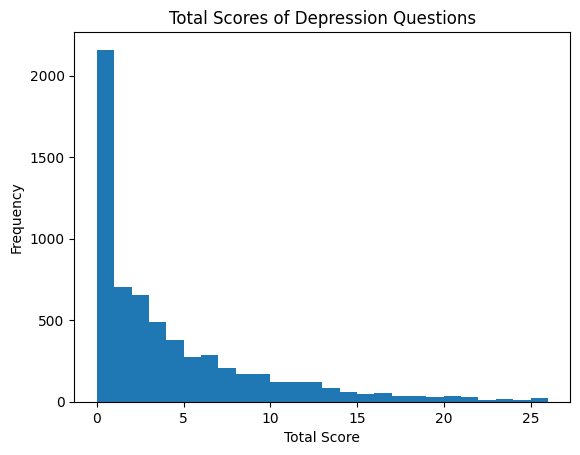

In [4]:
# counts of total sums across all questions of last 10 columns only add if value is 1, 2, 3
df["DPQSUM"] = df.iloc[:, -10:].apply(lambda x: x[x.isin([1, 2, 3])].sum(), axis=1)

# histogram of the sums
plt.hist(df["DPQSUM"], bins=range(0, 27, 1))
plt.title("Total Scores of Depression Questions")
plt.xlabel("Total Score")
plt.ylabel("Frequency")
plt.show()

Load in the other data sets for prediction and casual understanding of depression scores

In [5]:
# ALQ: Alcohol Use
with open("datasets/ALQ_L.xpt", "rb") as f:
    alq_df = pd.DataFrame(XportReader(f))

# HOQ: Household Questions (exact meaning uncertain)
with open("datasets/HOQ_L.xpt", "rb") as f:
    hoq_df = pd.DataFrame(XportReader(f))

# INQ: Income
with open("datasets/INQ_L.xpt", "rb") as f:
    inq_df = pd.DataFrame(XportReader(f))

# OCQ: Occupation
with open("datasets/OCQ_L.xpt", "rb") as f:
    ocq_df = pd.DataFrame(XportReader(f))

# PAQ: Physical Activity Questions
with open("datasets/PAQ_L.xpt", "rb") as f:
    paq_df = pd.DataFrame(XportReader(f))

# SLQ: Sleep-related Questions (exact meaning uncertain)
with open("datasets/SLQ_L.xpt", "rb") as f:
    slq_df = pd.DataFrame(XportReader(f))

# SMQ: Smoking
with open("datasets/SMQ_L.xpt", "rb") as f:
    smq_df = pd.DataFrame(XportReader(f))

# SMQRTU: Additional Smoking-related Questions (exact meaning uncertain)
with open("datasets/SMQRTU_L.xpt", "rb") as f:
    smqrtu_df = pd.DataFrame(XportReader(f))

# WHQ: Weight History Questions
with open("datasets/WHQ_L.xpt", "rb") as f:
    whq_df = pd.DataFrame(XportReader(f))

Overlapping SEQNs among all datasets

In [6]:
dataframes = [alq_df, df, hoq_df, inq_df, ocq_df, paq_df, slq_df, smq_df, smqrtu_df, whq_df]

common_seqn = set(dataframes[0]["SEQN"])
for df in dataframes[1:]:
    common_seqn = common_seqn.intersection(df["SEQN"])

print("Number of SEQNs in all dataframes:", len(common_seqn))

Number of SEQNs in all dataframes: 6337


In [7]:
merged_df = reduce(lambda left, right: pd.merge(left, right, on='SEQN', how='inner'), dataframes)

display(merged_df)

,SEQN,ALQ111,ALQ121,ALQ130,ALQ142,ALQ270,ALQ280,ALQ151,ALQ170,DPQ010,...,SMQ690D,SMQ690E,SMQ690K,SMQ863,SMQ690F,SMDANY,WHD010,WHD020,WHD050,WHQ070
0,130378.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,71.0,190.0,200.0,1.0
1,130379.0,1.0,2.0,3.0,0.0,NaN,NaN,2.0,NaN,0.0,...,NaN,NaN,NaN,2.0,NaN,2.0,70.0,220.0,220.0,2.0
2,130380.0,1.0,10.0,1.0,0.0,NaN,NaN,2.0,NaN,0.0,...,NaN,NaN,NaN,2.0,NaN,2.0,60.0,150.0,165.0,1.0
3,130386.0,1.0,4.0,2.0,10.0,0.0,10.0,2.0,0.0,0.0,...,NaN,NaN,NaN,2.0,NaN,2.0,68.0,200.0,180.0,2.0
4,130387.0,1.0,0.0,NaN,NaN,NaN,NaN,2.0,NaN,0.0,...,NaN,NaN,NaN,2.0,NaN,2.0,67.0,215.0,215.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6332,142305.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,61.0,137.0,134.0,2.0
6333,142307.0,1.0,10.0,1.0,0.0,NaN,NaN,2.0,NaN,0.0,...,NaN,NaN,NaN,2.0,NaN,1.0,61.0,206.0,235.0,1.0
6334,142308.0,1.0,8.0,2.0,0.0,NaN,NaN,2.0,NaN,0.0,...,NaN,NaN,NaN,2.0,NaN,2.0,69.0,174.0,180.0,1.0
6335,142309.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,2.0,NaN,2.0,69.0,200.0,170.0,2.0


In [8]:
# Fix physical activity columns to be standardized

unit_conversion = {'D': 365, 'W': 52.14, 'M': 12, 'Y': 1}

def standardize_frequency(row, freq_col, unit_col):
    if pd.isna(row[unit_col]) or pd.isna(row[freq_col]):
        return None  
    return row[freq_col] * unit_conversion.get(row[unit_col], 1)

merged_df['PAD790_annualized'] = merged_df.apply(
    lambda row: standardize_frequency(row, 'PAD790Q', 'PAD790U'), axis=1)

merged_df['PAD810_annualized'] = merged_df.apply(
    lambda row: standardize_frequency(row, 'PAD810Q', 'PAD810U'), axis=1)

merged_df['PAD790_total_minutes'] = merged_df['PAD790_annualized'] * merged_df['PAD800']
merged_df['PAD810_total_minutes'] = merged_df['PAD810_annualized'] * merged_df['PAD820']

merged_df = merged_df.drop(columns=['PAD800', 'PAD820'])
merged_df = merged_df.drop(columns=['PAD790Q', 'PAD790U', 'PAD810Q', 'PAD810U'])

In [9]:
# missingness percentage for each column
missingness = merged_df.isnull().sum()
missingness = missingness[missingness > 0]
missingness = missingness.sort_values(ascending=False)
missingness = missingness / len(merged_df) * 100
for i, v in missingness.items():
    print(f"{i}: {v:.2f}%")

# drop columns with more than 65% missing values
merged_df = merged_df.drop(columns=missingness[missingness > 40].index)

merged_df = merged_df.dropna()

SMD630: 100.00%
SMQ621: 100.00%
SMQ690E: 99.87%
SMQ740: 99.64%
SMQ690B: 99.64%
SMQ690D: 99.37%
SMQ690G: 99.31%
SMQ845: 99.31%
SMQ690K: 99.24%
SMQ690F: 98.64%
SMQ690C: 98.09%
SMQ770: 98.09%
SMD641: 96.99%
SMQ849: 94.24%
SMQ725: 87.68%
SMQ720: 87.61%
SMQ710: 87.61%
SMQ690A: 87.55%
SMD650: 85.61%
SMD100MN: 85.61%
OCQ210: 82.83%
ALQ170: 62.79%
ALQ280: 62.73%
ALQ270: 62.66%
SMQ040: 60.27%
OCQ383: 58.32%
IND310: 54.85%
PAD810_total_minutes: 54.62%
OCQ180: 49.05%
OCQ215: 45.84%
ALQ130: 35.79%
ALQ142: 35.58%
DPQ100: 34.24%
ALQ151: 22.66%
ALQ121: 22.33%
PAD790_total_minutes: 20.61%
INDFMMPI: 20.29%
SMDANY: 13.51%
ALQ111: 13.51%
SMQ863: 13.44%
SMQ851: 13.33%
SMQ846: 13.27%
SMQ681: 13.27%
DPQ090: 13.11%
DPQ080: 13.08%
DPQ070: 13.08%
DPQ060: 13.05%
DPQ050: 13.00%
DPQ040: 12.99%
DPQ030: 12.96%
DPQ020: 12.92%
DPQ010: 12.91%
INDFMMPC: 8.21%
INQ300: 8.16%
HOD051: 7.05%
SLD013: 1.06%
SLD012: 1.03%
PAD790_annualized: 0.11%
PAD810_annualized: 0.11%
PAD680: 0.09%
SMQ020: 0.03%


In [10]:
# need just one column for depression score not individual questions, but keep dpq sum column
merged_df = merged_df.drop(columns=merged_df.columns[merged_df.columns.str.startswith("DPQ") & ~merged_df.columns.str.startswith("DPQSUM")])

# dpqsum at end
merged_df = merged_df[[c for c in merged_df if c != 'DPQSUM'] + ['DPQSUM']]


In [11]:
# split up target (dpqsum) two different ways: binary (depressed or not) and continuous (minimal, mild, moderate, moderately severe, severe)
# Binary: 0-9 not depressed, 10-27 depressed
# Continuous: 0-4 minimal, 5-9 mild, 10-14 moderate, 15-19 moderately severe, 20-27 severe

# add binary target
merged_df["DEPRESSED"] = merged_df["DPQSUM"].apply(lambda x: 1 if x >= 10 else 0)
# add continuous target 1-5
merged_df["DEPRESSION_LEVEL"] = merged_df["DPQSUM"].apply(lambda x: 1 if x < 5 else 2 if x < 10 else 3 if x < 15 else 4 if x < 20 else 5)

# distribution of these targets
print("Binary Target Distribution:")
print(merged_df["DEPRESSED"].value_counts())
print("Continuous Target Distribution:")
print(merged_df["DEPRESSION_LEVEL"].value_counts())



Binary Target Distribution:
0    1688
1     363
Name: DEPRESSED, dtype: int64
Continuous Target Distribution:
1    1131
2     557
3     234
4      81
5      48
Name: DEPRESSION_LEVEL, dtype: int64


In [12]:
not_depressed = merged_df[merged_df['DEPRESSED'] == 0]
depressed = merged_df[merged_df['DEPRESSED'] == 1]

# randomly remove some not depressed samples to balance the dataset
not_depressed_downsampled = resample(not_depressed, 
                                     replace=False,
                                     n_samples=len(depressed),
                                     random_state=42)

balanced_df = pd.concat([not_depressed_downsampled, depressed])
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print("New Binary Target Distribution:")
print(balanced_df['DEPRESSED'].value_counts())

New Binary Target Distribution:
0    363
1    363
Name: DEPRESSED, dtype: int64


In [13]:
# remove dpqsum column
balanced_df = balanced_df.drop(columns="DPQSUM")

In [14]:
display(balanced_df)

,SEQN,ALQ111,ALQ121,ALQ130,ALQ142,ALQ151,HOD051,INDFMMPI,INDFMMPC,INQ300,...,SMDANY,WHD010,WHD020,WHD050,WHQ070,PAD790_annualized,PAD810_annualized,PAD790_total_minutes,DEPRESSED,DEPRESSION_LEVEL
0,139602.0,1.0,10.0,3.0,0.0,2.0,5.0,1.26,1.0,2.0,...,1.0,57.0,151.0,162.0,1.0,52.14,0.00,1042.8,0,2
1,135959.0,1.0,9.0,2.0,0.0,2.0,7.0,1.90,3.0,1.0,...,2.0,63.0,120.0,135.0,2.0,365.00,0.00,65700.0,1,4
2,137493.0,1.0,8.0,4.0,8.0,2.0,5.0,0.95,1.0,2.0,...,2.0,66.0,335.0,320.0,1.0,260.70,156.42,23463.0,1,5
3,135938.0,1.0,5.0,1.0,10.0,2.0,3.0,5.00,3.0,1.0,...,2.0,60.0,105.0,105.0,2.0,365.00,52.14,10950.0,0,1
4,137139.0,1.0,10.0,1.0,0.0,1.0,5.0,1.22,1.0,2.0,...,1.0,66.0,228.0,265.0,2.0,36.00,0.00,1080.0,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
721,134147.0,1.0,6.0,1.0,0.0,2.0,1.0,5.00,3.0,1.0,...,2.0,65.0,180.0,180.0,1.0,156.42,24.00,4692.6,0,1
722,130621.0,1.0,4.0,2.0,10.0,2.0,6.0,5.00,3.0,1.0,...,2.0,69.0,220.0,215.0,2.0,104.28,0.00,6256.8,0,2
723,135094.0,1.0,3.0,3.0,6.0,2.0,5.0,5.00,3.0,1.0,...,1.0,70.0,210.0,200.0,2.0,260.70,104.28,15642.0,0,1
724,133298.0,1.0,3.0,1.0,5.0,2.0,9.0,5.00,3.0,1.0,...,2.0,62.0,130.0,150.0,1.0,156.42,52.14,9385.2,1,3


In [15]:
X = balanced_df.drop(columns=["DEPRESSED", "DEPRESSION_LEVEL"])
y_binary = balanced_df["DEPRESSED"]
y_continuous = balanced_df["DEPRESSION_LEVEL"]
X_train, X_test, y_binary_train, y_binary_test, y_continuous_train, y_continuous_test = train_test_split(X, y_binary, y_continuous, test_size=0.2, random_state=42)

In [16]:
# Fix non-numeric SLQ columns

def time_to_minutes(time_str):
    try:
        if pd.isna(time_str) or not isinstance(time_str, str) or ":" not in time_str:
            return None  # Skip invalid values
        h, m = map(int, time_str.split(":"))
        return h * 60 + m
    except Exception as e:
        print(f"Error with value: {time_str} - {e}")
        return None

time_columns = ['SLQ300', 'SLQ310', 'SLQ320', 'SLQ330']
for col in time_columns:
    X_train[col] = X_train[col].apply(time_to_minutes)
    X_test[col] = X_test[col].apply(time_to_minutes)

Try Random Forest model

In [17]:
randomForest = RandomForestClassifier(random_state=42)
randomForest.fit(X_train, y_binary_train)

y_binary_pred = randomForest.predict(X_test)
print("Binary Target Accuracy:", accuracy_score(y_binary_test, y_binary_pred))
print("Binary Target Classification Report:")
print(classification_report(y_binary_test, y_binary_pred))

Binary Target Accuracy: 0.6643835616438356
Binary Target Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.70      0.70        80
           1       0.63      0.62      0.63        66

    accuracy                           0.66       146
   macro avg       0.66      0.66      0.66       146
weighted avg       0.66      0.66      0.66       146

